# Minimum Edit Distance

Minimum Edit distance is the minimum number of editing operations i.e Insertion, Deletion, Substitution needed to transform one string to another. 

When computing the minimum edit distance, you would start with a source word and transform it into the target word. Let's look at the following example: 

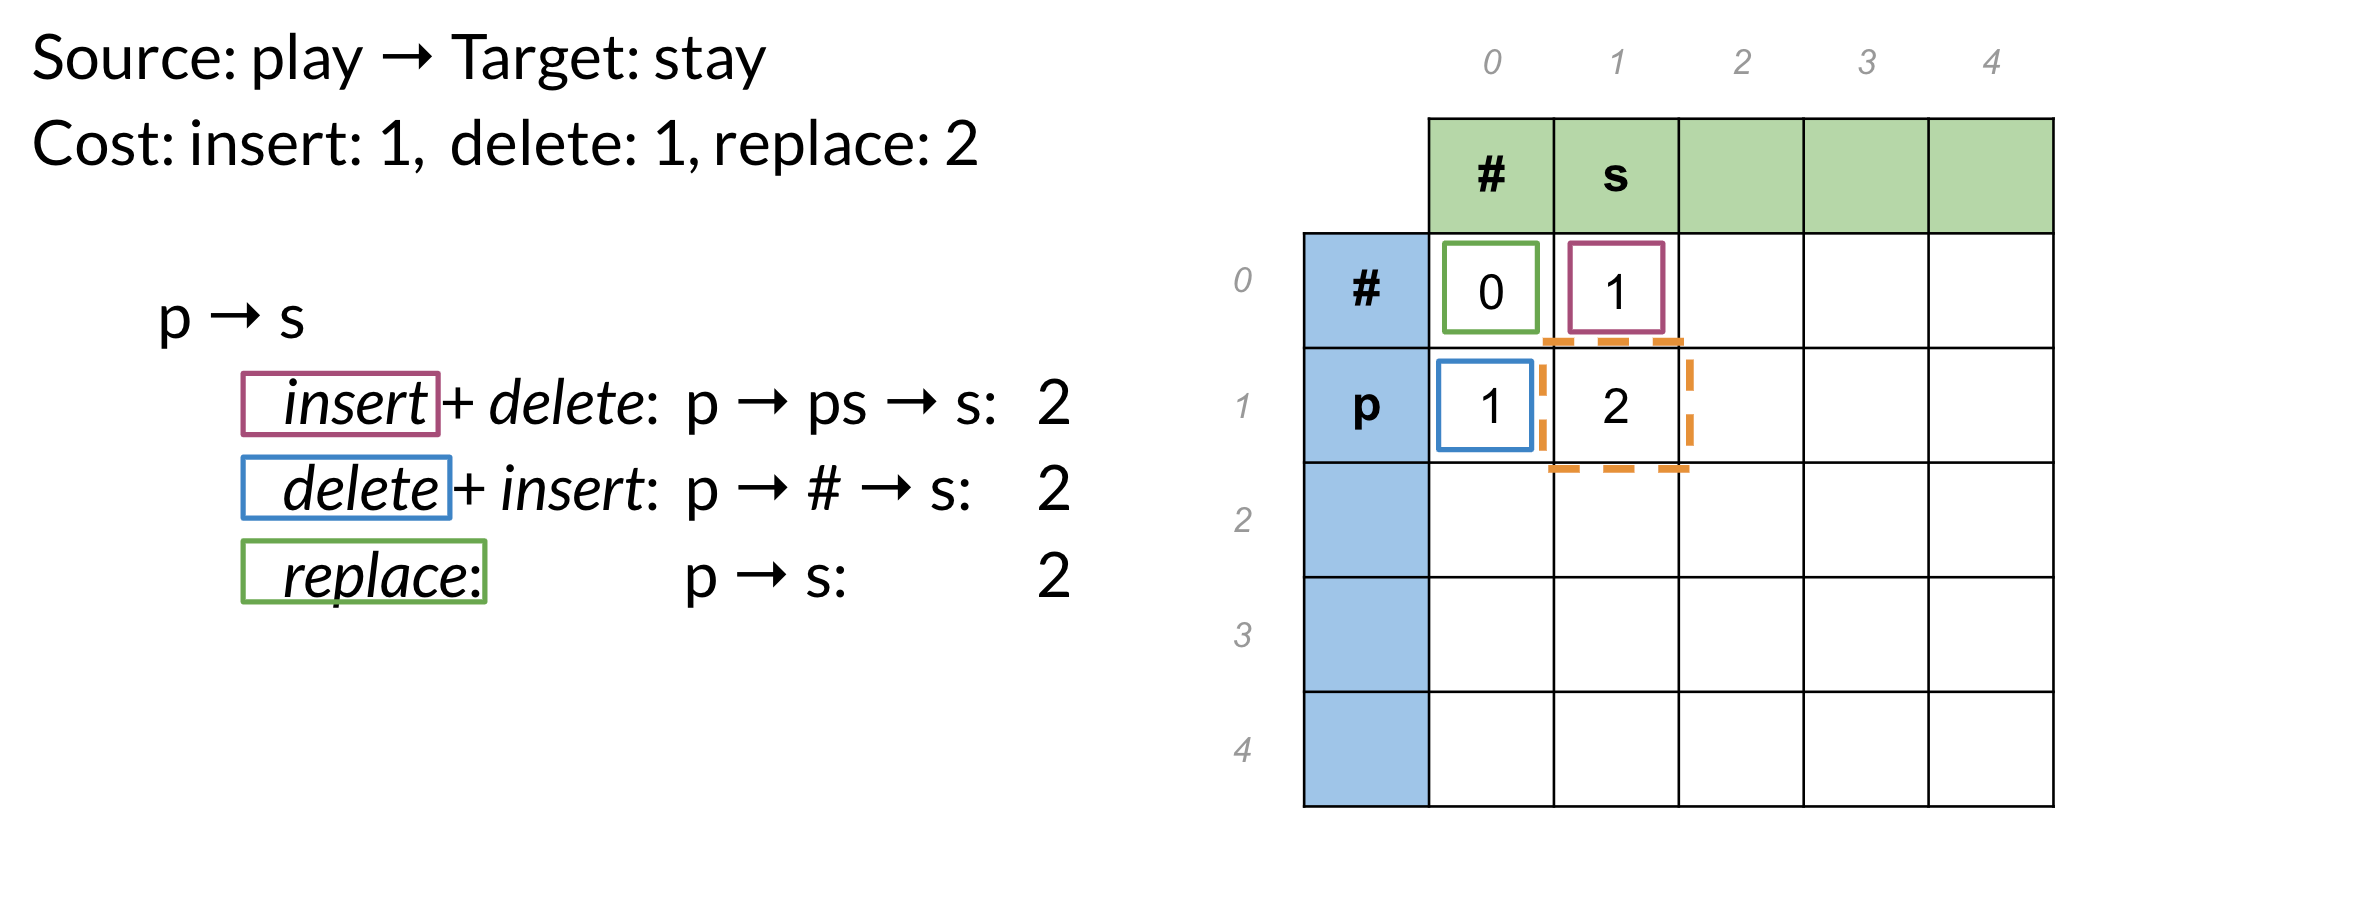

To go from #→##→# you need a cost of 0. From  p→#p→# you get 1, because that is the cost of a delete.  p→sp→s is 2 because that is the minimum cost one could use to get from p to s. You can keep going this way by populating one element at a time, but it turns out there is a faster way to do this. You will learn about it next. 

# Minimum edit distance algorithm II

To populate the following table:

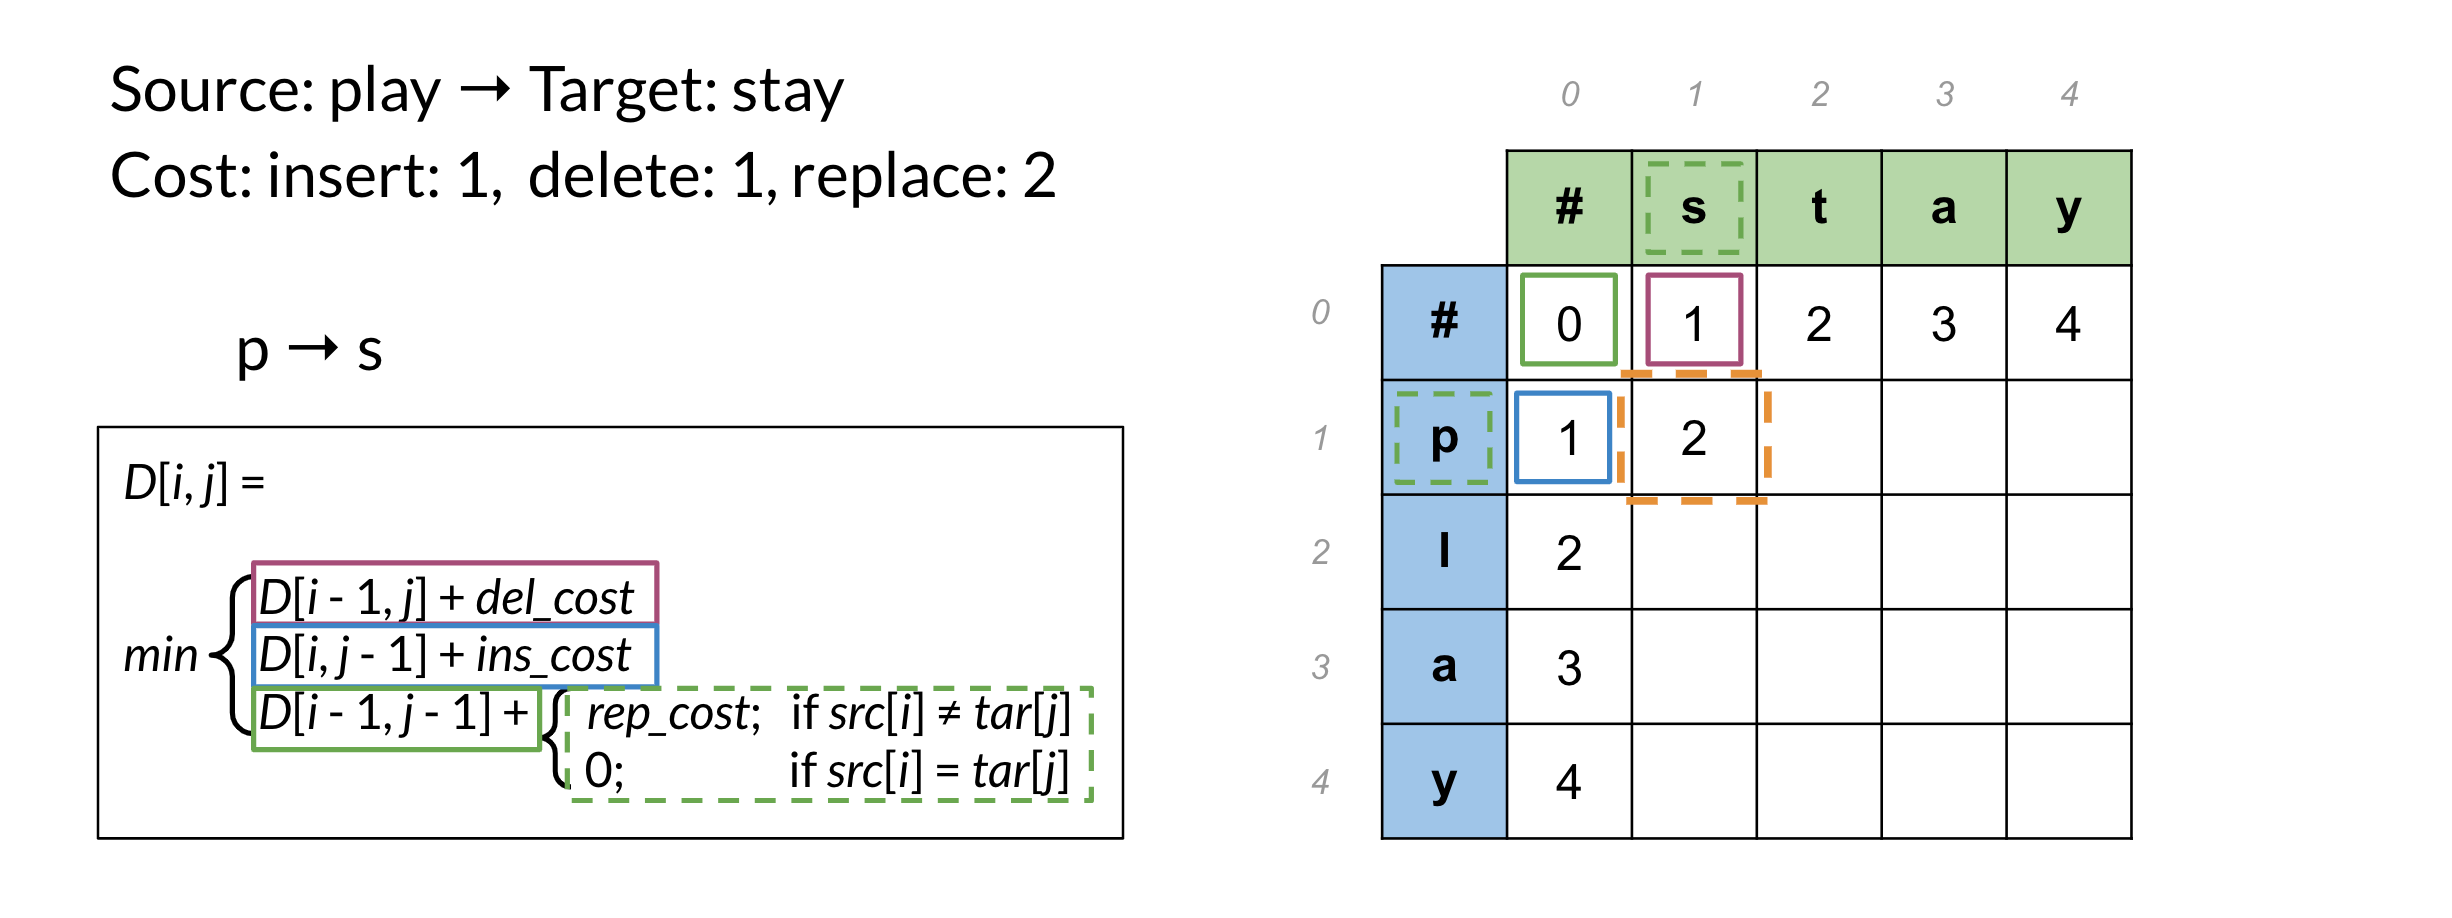

There are three equations: 

    D[i,j] = D[i-1, j] + del_cost: this indicates you want to populate the current cell (i,j) by using the cost in the cell found directly above. 

    D[i,j] = D[i, j-1] + ins_cost: this indicates you want to populate the current cell (i,j) by using the cost in the cell found directly to its left. 

    D[i,j] = D[i-1, j-1] + rep_cost: the rep cost can be 2 or 0 depending if you are going to actually replace it or not. 

At every time step you check the three possible paths where you can come from and you select the least expensive one. Once you are done, you get the following: 

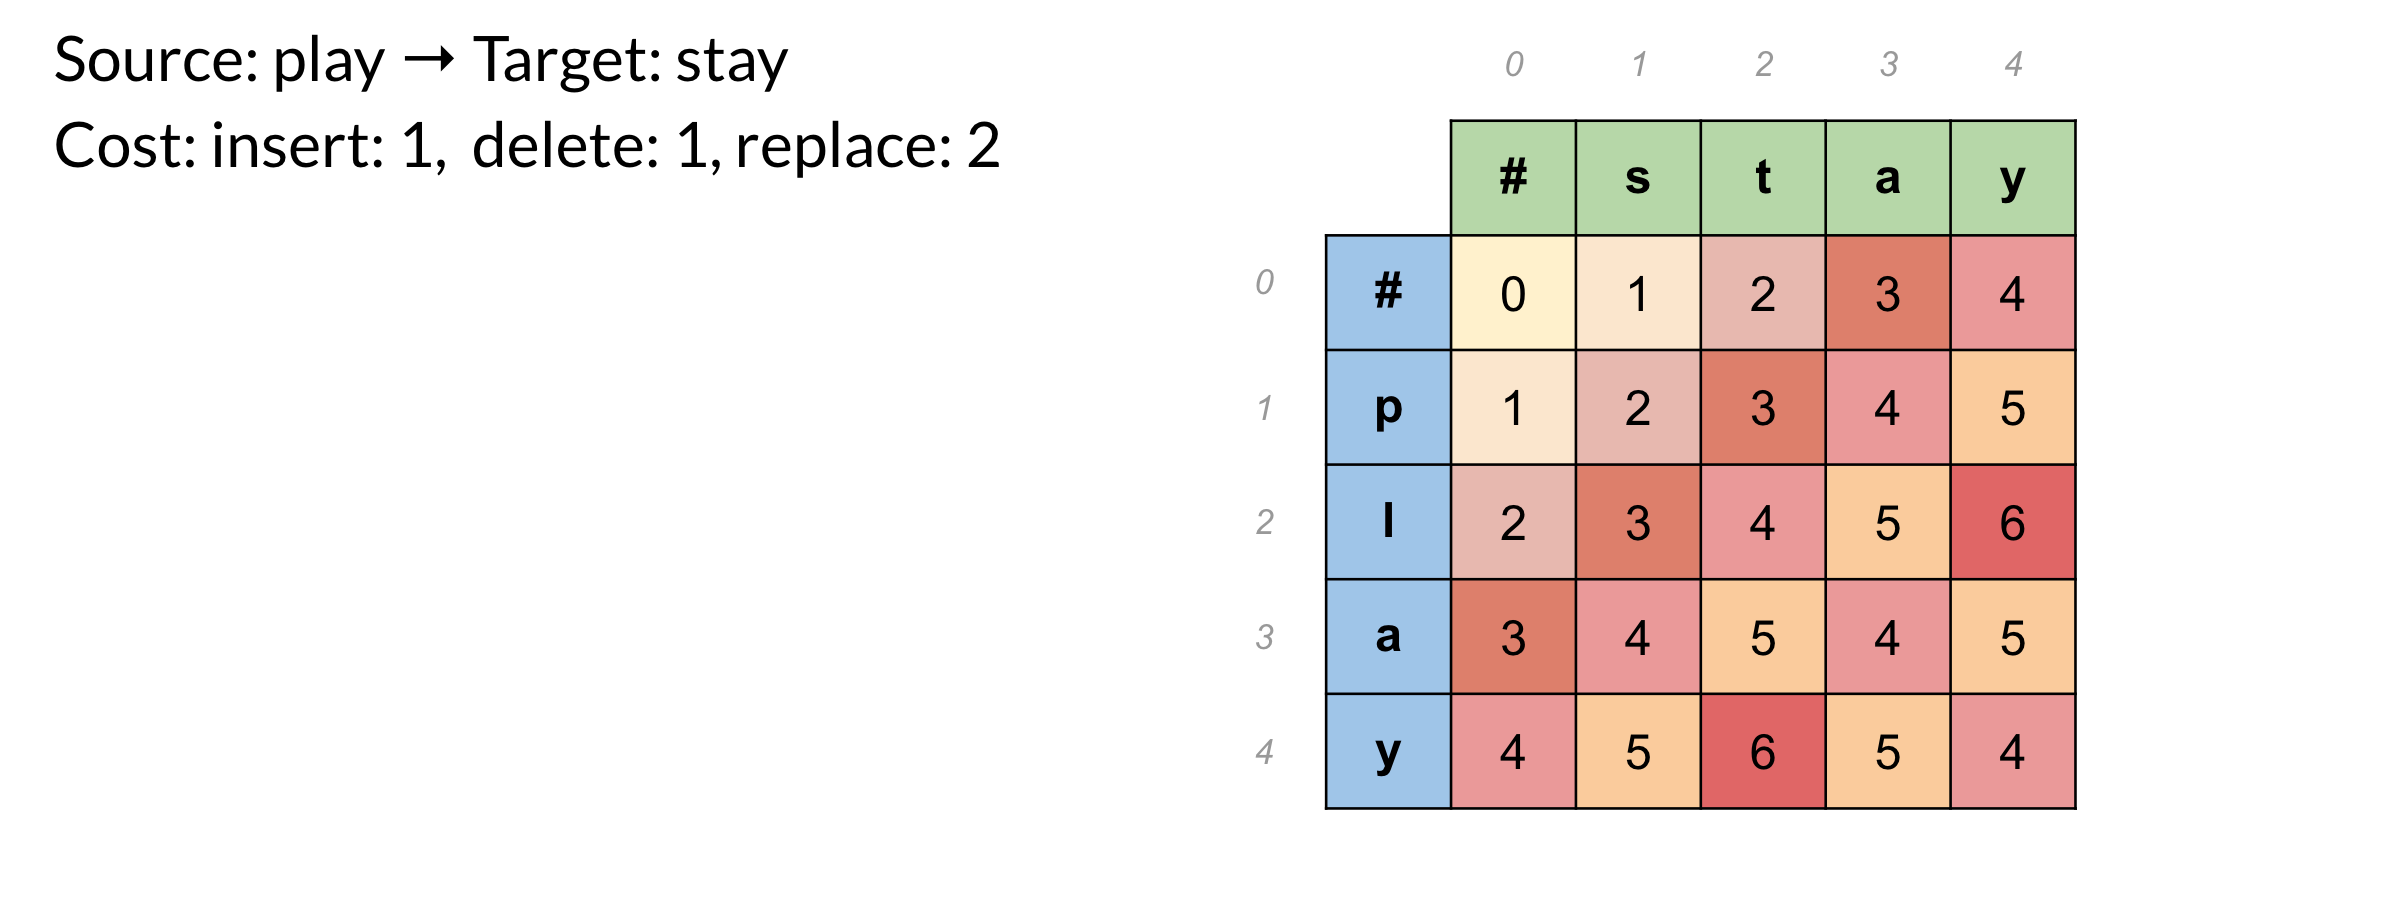

## Data Preprocessing

In [64]:
import re
from collections import Counter
import numpy as np
import pandas as pd

import w1_unittest

In [65]:
def process_data(file_name):
    """
    Input: 
        A file_name which is found in your current directory. You just have to read it in. 
    Output: 
        words: a list containing all the words in the corpus (text file you read) in lower case. 
    """
    words = [] # return this variable correctly

    ### START CODE HERE ### 
    
    #Open the file, read its contents into a string variable
    
    with open(file_name, 'r') as file:
        text = file.read()
    
    # convert all letters to lower case
    text = text.lower()
    
    #Convert every word to lower case and return them in a list.
    words = re.findall(r"\w+", text)
    ### END CODE HERE ###
    
    return words

In [66]:
word_l = process_data('./data/shakespeare.txt')
vocab = set(word_l)  # this will be your new vocabulary
print(f"The first ten words in the text are: \n{word_l[0:10]}")
print(f"There are {len(vocab)} unique words in the vocabulary.")

The first ten words in the text are: 
['o', 'for', 'a', 'muse', 'of', 'fire', 'that', 'would', 'ascend', 'the']
There are 6116 unique words in the vocabulary.


### get_count

Implement a `get_count` function that returns a dictionary
- The dictionary's keys are words
- The value for each word is the number of times that word appears in the corpus. 

For example, given the following sentence: **"I am happy because I am learning"**, your dictionary should return the following: 
<table style="width:20%">

  <tr>
    <td> <b>Key </b>  </td>
    <td> <b>Value </b> </td> 


  </tr>
  <tr>
    <td> I  </td>
    <td> 2</td> 
 
  </tr>
   
  <tr>
    <td>am</td>
    <td>2</td> 
  </tr>

  <tr>
    <td>happy</td>
    <td>1</td> 
  </tr>
  
   <tr>
    <td>because</td>
    <td>1</td> 
  </tr>
  
   <tr>
    <td>learning</td>
    <td>1</td> 
  </tr>
</table>



In [67]:
def get_count(word_l):
    '''
    Input:
        word_l: a set of words representing the corpus. 
    Output:
        word_count_dict: The wordcount dictionary where key is the word and value is its frequency.
    '''
    
    word_count_dict = {}  # fill this with word counts
    ### START CODE HERE 
    for word in word_l:
        if word in word_count_dict:
            word_count_dict[word] += 1
        else:
            word_count_dict[word] = 1
            
    ### END CODE HERE ### 
    return word_count_dict

In [68]:
word_count_dict = get_count(word_l)
print(f"There are {len(word_count_dict)} key values pairs")
print(f"The count for the word 'thee' is {word_count_dict.get('thee',0)}")

There are 6116 key values pairs
The count for the word 'thee' is 240


### get_probs
Given the dictionary of word counts, compute the probability that each word will appear if randomly selected from the corpus of words.

$$P(w_i) = \frac{C(w_i)}{M} \tag{Eqn-2}$$
where 

$C(w_i)$ is the total number of times $w_i$ appears in the corpus.

$M$ is the total number of words in the corpus.

For example, the probability of the word 'am' in the sentence **'I am happy because I am learning'** is:

$$P(am) = \frac{C(w_i)}{M} = \frac {2}{7} \tag{Eqn-3}.$$

**Instructions:** Implement `get_probs` function which gives you the probability 
that a word occurs in a sample. This returns a dictionary where the keys are words, and the value for each word is its probability in the corpus of words.

In [69]:
def get_probs(word_count_dict):
    '''
    Input:
        word_count_dict: The wordcount dictionary where key is the word and value is its frequency.
    Output:
        probs: A dictionary where keys are the words and the values are the probability that a word will occur. 
    '''
    probs = {}  # return this variable correctly
    
    ### START CODE HERE ###
    total = sum(word_count_dict.values())
    
    # get the total count of words for all words in the dictionary
    for key in word_count_dict.keys():
        probs[key] = word_count_dict[key] / total
    
    ### END CODE HERE ###
    return probs

In [70]:
probs = get_probs(word_count_dict)
print(f"Length of probs is {len(probs)}")
print(f"P('thee') is {probs['thee']:.4f}")

Length of probs is 6116
P('thee') is 0.0045


## String Manipulations

Now that you have computed $P(w_i)$ for all the words in the corpus, you will write a few functions to manipulate strings so that you can edit the erroneous strings and return the right spellings of the words. In this section, you will implement four functions: 

* `delete_letter`: given a word, it returns all the possible strings that have **one character removed**. 
* `switch_letter`: given a word, it returns all the possible strings that have **two adjacent letters switched**.
* `replace_letter`: given a word, it returns all the possible strings that have **one character replaced by another different letter**.
* `insert_letter`: given a word, it returns all the possible strings that have an **additional character inserted**. 


### delete_letter

**Instructions for delete_letter():** Implement a `delete_letter()` function that, given a word, returns a list of strings with one character deleted. 

For example, given the word **nice**, it would return the set: {'ice', 'nce', 'nic', 'nie'}. 

**Step 1:** Create a list of 'splits'. This is all the ways you can split a word into Left and Right: For example,   
'nice is split into : `[('', 'nice'), ('n', 'ice'), ('ni', 'ce'), ('nic', 'e'), ('nice', '')]`
This is common to all four functions (delete, replace, switch, insert).


In [71]:
def delete_letter(word, verbose=False):
    '''
    Input:
        word: the string/word for which you will generate all possible words 
                in the vocabulary which have 1 missing character
    Output:
        delete_l: a list of all possible strings obtained by deleting 1 character from word
    '''
    
    delete_l = []
    split_l = []
    
    ### START CODE HERE ###
    split_l = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    delete_l = [L + R[1:] for L, R in split_l if R]
    ### END CODE HERE ###

    if verbose: print(f"input word {word}, \nsplit_l = {split_l}, \ndelete_l = {delete_l}")

    return  delete_l

In [72]:
delete_word_l = delete_letter(word="cans",
                        verbose=True)

input word cans, 
split_l = [('', 'cans'), ('c', 'ans'), ('ca', 'ns'), ('can', 's'), ('cans', '')], 
delete_l = ['ans', 'cns', 'cas', 'can']


In [73]:
print(f"Number of outputs of delete_letter('at') is {len(delete_letter('at'))}")

Number of outputs of delete_letter('at') is 2


In [74]:
def switch_letter(word, verbose=False):
    '''
    Input:
        word: input string
     Output:
        switches: a list of all possible strings with one adjacent charater switched
    ''' 
    
    switch_l = []
    split_l = []
    
    ### START CODE HERE ###
    switch_l = [
        word[:i] + word[i+1] + word[i] + word[i+2:]
        for i in range(len(word) - 1)
    ]
    
    ### END CODE HERE ###
    
    if verbose: print(f"Input word = {word} \nsplit_l = {split_l} \nswitch_l = {switch_l}") 
    
    return switch_l

In [75]:
switch_word_l = switch_letter(word="eta",
                         verbose=True)

Input word = eta 
split_l = [] 
switch_l = ['tea', 'eat']


In [76]:
print(f"Number of outputs of switch_letter('at') is {len(switch_letter('at'))}")

Number of outputs of switch_letter('at') is 1


In [77]:
help(switch_letter)

Help on function switch_letter in module __main__:

switch_letter(word, verbose=False)
    Input:
        word: input string
     Output:
        switches: a list of all possible strings with one adjacent charater switched



### replace_letter
**Instructions for replace_letter()**: Now implement a function that takes in a word and returns a list of strings with one **replaced letter** from the original word. 

**Step 1:** is the same as in `delete_letter()`

**Step 2:** A list comprehension or for loop which form strings by replacing letters.  This can be of the form:  
`[f(a,b,c) for a, b in splits if condition for c in string]`   Note the use of the second for loop.  
It is expected in this routine that one or more of the replacements will include the original word. For example, replacing the first letter of 'ear' with 'e' will return 'ear'.

**Step 3:** Remove the original input letter from the output.


In [78]:

def replace_letter(word, verbose=False):
    '''
    Input:
        word: the input string/word 
    Output:
        replaces: a list of all possible strings where we replaced one letter from the original word. 
    ''' 
    
    letters = 'abcdefghijklmnopqrstuvwxyz'
    
    replace_l = []
    split_l = []
    
    ### START CODE HERE ###
    split_l = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    replace_l = [
        word[:i] + l + word[i+1:]
        for i in range(len(word))
        for l in letters
        if word[i] != l
    ]
    ### END CODE HERE ###
    
    # Sort the list, for easier viewing
    replace_l = sorted(replace_l)
    
    if verbose: print(f"Input word = {word} \nsplit_l = {split_l} \nreplace_l {replace_l}")   
    
    return replace_l

In [79]:
replace_l = replace_letter(word='can',
                              verbose=True)

Input word = can 
split_l = [('', 'can'), ('c', 'an'), ('ca', 'n'), ('can', '')] 
replace_l ['aan', 'ban', 'caa', 'cab', 'cac', 'cad', 'cae', 'caf', 'cag', 'cah', 'cai', 'caj', 'cak', 'cal', 'cam', 'cao', 'cap', 'caq', 'car', 'cas', 'cat', 'cau', 'cav', 'caw', 'cax', 'cay', 'caz', 'cbn', 'ccn', 'cdn', 'cen', 'cfn', 'cgn', 'chn', 'cin', 'cjn', 'ckn', 'cln', 'cmn', 'cnn', 'con', 'cpn', 'cqn', 'crn', 'csn', 'ctn', 'cun', 'cvn', 'cwn', 'cxn', 'cyn', 'czn', 'dan', 'ean', 'fan', 'gan', 'han', 'ian', 'jan', 'kan', 'lan', 'man', 'nan', 'oan', 'pan', 'qan', 'ran', 'san', 'tan', 'uan', 'van', 'wan', 'xan', 'yan', 'zan']


In [80]:
print(f"Number of outputs of replace_letter('at') is {len(replace_letter('at'))}")

Number of outputs of replace_letter('at') is 50


insert_letter

**Instructions for insert_letter()**: Now implement a function that takes in a word and returns a list with a letter inserted at every offset.

**Step 1:** is the same as in `delete_letter()`

**Step 2:** This can be a list comprehension of the form:  
`[f(a,b,c) for a, b in splits if condition for c in string]`   

In [81]:
def insert_letter(word, verbose=False):
    '''
    Input:
        word: the input string/word 
    Output:
        inserts: a set of all possible strings with one new letter inserted at every offset
    ''' 
    letters = 'abcdefghijklmnopqrstuvwxyz'
    insert_l = []
    split_l = []
    
    ### START CODE HERE ###
    split_l = [(word[:i], word[i:]) for i in range(len(word)+1)]
    
    insert_l = [word[:i] + letter + word[i:] for i in range(len(word) + 1) for letter in letters]

    ### END CODE HERE ###
    
    if verbose: print(f"Input word {word} \nsplit_l = {split_l} \ninsert_l = {insert_l}")
    
    return insert_l

In [82]:
insert_l = insert_letter('at', True)
print(f"Number of strings output by insert_letter('at') is {len(insert_l)}")

Input word at 
split_l = [('', 'at'), ('a', 't'), ('at', '')] 
insert_l = ['aat', 'bat', 'cat', 'dat', 'eat', 'fat', 'gat', 'hat', 'iat', 'jat', 'kat', 'lat', 'mat', 'nat', 'oat', 'pat', 'qat', 'rat', 'sat', 'tat', 'uat', 'vat', 'wat', 'xat', 'yat', 'zat', 'aat', 'abt', 'act', 'adt', 'aet', 'aft', 'agt', 'aht', 'ait', 'ajt', 'akt', 'alt', 'amt', 'ant', 'aot', 'apt', 'aqt', 'art', 'ast', 'att', 'aut', 'avt', 'awt', 'axt', 'ayt', 'azt', 'ata', 'atb', 'atc', 'atd', 'ate', 'atf', 'atg', 'ath', 'ati', 'atj', 'atk', 'atl', 'atm', 'atn', 'ato', 'atp', 'atq', 'atr', 'ats', 'att', 'atu', 'atv', 'atw', 'atx', 'aty', 'atz']
Number of strings output by insert_letter('at') is 78


### edit_one_letter

**Instructions**: Implement the `edit_one_letter` function to get all the possible edits that are one edit away from a word. The edits  consist of the replace, insert, delete, and optionally the switch operation. You should use the previous functions you have already implemented to complete this function. The 'switch' function  is a less common edit function, so its use will be selected by an "allow_switches" input argument.

Note that those functions return *lists* while this function should return a *python set*. Utilizing a set eliminates any duplicate entries.

In [83]:
def edit_one_letter(word, allow_switches = True):
    """
    Input:
        word: the string/word for which we will generate all possible wordsthat are one edit away.
    Output:
        edit_one_set: a set of words with one possible edit. Please return a set. and not a list.
    """
    
    edit_one_set = set()
    
    ### START CODE HERE ###
    edit_one_set.update(delete_letter(word))
    if allow_switches:
        edit_one_set.update(switch_letter(word))
    edit_one_set.update(replace_letter(word))
    edit_one_set.update(insert_letter(word))    ### END CODE HERE ###
    
    # return this as a set and not a list
    return set(edit_one_set)

In [84]:
tmp_word = "at"
tmp_edit_one_set = edit_one_letter(tmp_word)
# turn this into a list to sort it, in order to view it
tmp_edit_one_l = sorted(list(tmp_edit_one_set))

print(f"input word {tmp_word} \nedit_one_l \n{tmp_edit_one_l}\n")
print(f"The type of the returned object should be a set {type(tmp_edit_one_set)}")
print(f"Number of outputs from edit_one_letter('at') is {len(edit_one_letter('at'))}")

input word at 
edit_one_l 
['a', 'aa', 'aat', 'ab', 'abt', 'ac', 'act', 'ad', 'adt', 'ae', 'aet', 'af', 'aft', 'ag', 'agt', 'ah', 'aht', 'ai', 'ait', 'aj', 'ajt', 'ak', 'akt', 'al', 'alt', 'am', 'amt', 'an', 'ant', 'ao', 'aot', 'ap', 'apt', 'aq', 'aqt', 'ar', 'art', 'as', 'ast', 'ata', 'atb', 'atc', 'atd', 'ate', 'atf', 'atg', 'ath', 'ati', 'atj', 'atk', 'atl', 'atm', 'atn', 'ato', 'atp', 'atq', 'atr', 'ats', 'att', 'atu', 'atv', 'atw', 'atx', 'aty', 'atz', 'au', 'aut', 'av', 'avt', 'aw', 'awt', 'ax', 'axt', 'ay', 'ayt', 'az', 'azt', 'bat', 'bt', 'cat', 'ct', 'dat', 'dt', 'eat', 'et', 'fat', 'ft', 'gat', 'gt', 'hat', 'ht', 'iat', 'it', 'jat', 'jt', 'kat', 'kt', 'lat', 'lt', 'mat', 'mt', 'nat', 'nt', 'oat', 'ot', 'pat', 'pt', 'qat', 'qt', 'rat', 'rt', 'sat', 'st', 't', 'ta', 'tat', 'tt', 'uat', 'ut', 'vat', 'vt', 'wat', 'wt', 'xat', 'xt', 'yat', 'yt', 'zat', 'zt']

The type of the returned object should be a set <class 'set'>
Number of outputs from edit_one_letter('at') is 129


In [85]:
def edit_two_letters(word, allow_switches = True):
    '''
    Input:
        word: the input string/word 
    Output:
        edit_two_set: a set of strings with all possible two edits
    '''
    
    edit_two_set = set()
    
    ### START CODE HERE ###
    edit_one = edit_one_letter(word,allow_switches=allow_switches)
    for w in edit_one:
        if w:
            edit_two = edit_one_letter(w,allow_switches=allow_switches)
            edit_two_set.update(edit_two)
    ### END CODE HERE ###
    
    # return this as a set instead of a list
    return set(edit_two_set)

In [86]:
tmp_edit_two_set = edit_two_letters("a")
tmp_edit_two_l = sorted(list(tmp_edit_two_set))
print(f"Number of strings with edit distance of two: {len(tmp_edit_two_l)}")
print(f"First 10 strings {tmp_edit_two_l[:10]}")
print(f"Last 10 strings {tmp_edit_two_l[-10:]}")
print(f"The data type of the returned object should be a set {type(tmp_edit_two_set)}")
print(f"Number of strings that are 2 edit distances from 'at' is {len(edit_two_letters('at'))}")

Number of strings with edit distance of two: 2654
First 10 strings ['', 'a', 'aa', 'aaa', 'aab', 'aac', 'aad', 'aae', 'aaf', 'aag']
Last 10 strings ['zv', 'zva', 'zw', 'zwa', 'zx', 'zxa', 'zy', 'zya', 'zz', 'zza']
The data type of the returned object should be a set <class 'set'>
Number of strings that are 2 edit distances from 'at' is 7154


### Suggest Spelling Suggestions

Now you will use your `edit_two_letters` function to get a set of all the possible 2 edits on your word. You will then use those strings to get the most probable word you meant to type a.k.a your typing suggestion.

<a name='ex-10'></a>
### get_corrections
**Instructions**: Implement `get_corrections`, which returns a list of zero to n possible suggestion tuples of the form (word, probability_of_word). 

**Step 1:** Generate suggestions for a supplied word: You'll use the edit functions you have developed. The 'suggestion algorithm' should follow this logic: 
* If the word is in the vocabulary, suggest the word. 
* Otherwise, if there are suggestions from `edit_one_letter` that are in the vocabulary, use those. 
* Otherwise, if there are suggestions from `edit_two_letters` that are in the vocabulary, use those. 
* Otherwise, suggest the input word.*  
* The idea is that words generated from fewer edits are more likely than words with more edits.


In [87]:
# example of logical operation on lists or sets
print( [] and ["a","b"] )
print( [] or ["a","b"] )
#example of Short circuit behavior
val1 =  ["Most","Likely"] or ["Less","so"] or ["least","of","all"]  # selects first, does not evalute remainder
print(val1)
val2 =  [] or [] or ["least","of","all"] # continues evaluation until there is a non-empty list
print(val2)

[]
['a', 'b']
['Most', 'Likely']
['least', 'of', 'all']


In [88]:
def get_corrections(word, probs, vocab, n=2, verbose = False):
    '''
    Input: 
        word: a user entered string to check for suggestions
        probs: a dictionary that maps each word to its probability in the corpus
        vocab: a set containing all the vocabulary
        n: number of possible word corrections you want returned in the dictionary
    Output: 
        n_best: a list of tuples with the most probable n corrected words and their probabilities.
    '''
    
    suggestions = []
    n_best = []
    
    ### START CODE HERE ###
    #Step 1: create suggestions as described above    
    suggestions = edit_one_letter(word).intersection(vocab)
                    
    #Step 2: determine probability of suggestions
    suggestions_probs = {word: probs[word] for word in suggestions if word in probs}

    #Step 3: Get all your best words and return the most probable top n_suggested words as n_best
    
    n_best = sorted(suggestions_probs.items(), key=lambda item: item[1], reverse=True)[:n]
    
    ### END CODE HERE ###
    
    if verbose: print("entered word = ", word, "\nsuggestions = ", suggestions)

    return n_best

In [89]:
# Test your implementation - feel free to try other words in my word
my_word = 'dys' 
tmp_corrections = get_corrections(my_word, probs, vocab, 2, verbose=True) # keep verbose=True
for i, word_prob in enumerate(tmp_corrections):
    print(f"word {i}: {word_prob[0]}, probability {word_prob[1]:.6f}")

# CODE REVIEW COMMENT: using "tmp_corrections" insteads of "cors". "cors" is not defined
print(f"data type of corrections {type(tmp_corrections)}")

entered word =  dys 
suggestions =  {'days', 'dye'}
word 0: days, probability 0.000410
word 1: dye, probability 0.000019
data type of corrections <class 'list'>


In [95]:
def min_edit_distance(source, target, ins_cost = 1, del_cost = 1, rep_cost = 2):
    '''
    Input: 
        source: a string corresponding to the string you are starting with
        target: a string corresponding to the string you want to end with
        ins_cost: an integer setting the insert cost
        del_cost: an integer setting the delete cost
        rep_cost: an integer setting the replace cost
    Output:
        D: a matrix of len(source)+1 by len(target)+1 containing minimum edit distances
        med: the minimum edit distance (med) required to convert the source string to the target
    '''
    # use deletion and insert cost as  1
    m = len(source)
    n = len(target)

    #initialize cost matrix with zeros and dimensions (m+1,n+1) 
    D = np.zeros((m+1, n+1), dtype=int) 
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    # Fill in column 0, from row 1 to row m
    for row in range(1,m+1): # Replace None with the proper range
        D[row,0] = D[row-1,0] + del_cost
        
    # Fill in row 0, for all columns from 1 to n
    for col in range(1,n+1): # Replace None with the proper range
        D[0,col] = D[0,col-1] + ins_cost
        
    # Loop through row 1 to row m
    for row in range(1,m+1): 
        
        # Loop through column 1 to column n
        for col in range(1,n+1):
            
            # Intialize r_cost to the 'replace' cost that is passed into this function
            r_cost = rep_cost
            
            # Check to see if source character at the previous row
            # matches the target character at the previous column, 
            if source[row-1] == target[col-1]:
                # Update the replacement cost to 0 if source and target are the same
                r_cost = 0
                
            # Update the cost at row, col based on previous entries in the cost matrix
            # Refer to the equation calculate for D[i,j] (the minimum of three calculated costs)
            D[row,col] = min([D[row-1,col]+del_cost, D[row,col-1]+ins_cost, D[row-1,col-1]+r_cost])
          
    # Set the minimum edit distance with the cost found at row m, column n
    med = D[m,n]
    
    ### END CODE HERE ###
    return D, med

In [96]:
# testing your implementation 
source =  'play'
target = 'stay'
matrix, min_edits = min_edit_distance(source, target)
print("minimum edits: ",min_edits, "\n")
idx = list('#' + source)
cols = list('#' + target)
df = pd.DataFrame(matrix, index=idx, columns= cols)
print(df)

minimum edits:  4 

   #  s  t  a  y
#  0  1  2  3  4
p  1  2  3  4  5
l  2  3  4  5  6
a  3  4  5  4  5
y  4  5  6  5  4


In [97]:
# testing implementation 
source =  'eer'
target = 'near'
matrix, min_edits = min_edit_distance(source, target)
print("minimum edits: ",min_edits, "\n")
idx = list(source)
idx.insert(0, '#')
cols = list(target)
cols.insert(0, '#')
df = pd.DataFrame(matrix, index=idx, columns= cols)
print(df)

minimum edits:  3 

   #  n  e  a  r
#  0  1  2  3  4
e  1  2  1  2  3
e  2  3  2  3  4
r  3  4  3  4  3
